In [1]:
from decoder_new import *
from encoder import *
from data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
from matplotlib import pyplot as plt



[nltk_data] Downloading package punkt to
[nltk_data]     /datasets/home/64/364/rhadden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


def validate(val_loader, encoder, decoder, criterion, maxSeqLen, vocablen, use_gpu = True):

    #Evaluation Mode
    decoder.eval()
    encoder.eval()

    
    
    
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        
        
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            if use_gpu:
                imgs = imgs.to(device)
                caps = caps.to(device)
            
            if (i % 1000) == 0:
                print('i: ',i)
                print('imgs: ',imgs)
                print('caps: ',caps)
                print('val_loader: ', val_loader)
                print('caplens: ',caplens)
            
            enc_out = encoder(imgs)
            actual_lengths = allcaps
            
            
            
            temperature = 1
            test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)

            test_pred_sample = test_pred[0].cpu().numpy()          

            
            
            if i % 100 == 0:
                # Convert word_ids to words
                sampled_caption = []
                for word_id in test_pred_sample:
                    word = vocab.idx2word[word_id]
                    sampled_caption.append(word)
                    if word == '<end>':
                        break
                sentence = ' '.join(sampled_caption)
                print ('sentence: ',sentence)            
                        
            
            for b in range(batch_size):
                flag = False
                for wi in range(maxSeqLen):
                    if test_pred[b, wi] == 2:
                        flag = True
                    if flag:
                        test_pred[b, wi] = 0
            
            if i % 1000 == 0:
                print('VAL: test pred: ', test_pred)
                print('VAL: test pred shape: ', test_pred.size())
        
            outputs = decoder(caps, enc_out, actual_lengths)
            if i % 1000 == 0:
                print('VAL: outputs shape: ', outputs.size())
            new_outputs = torch.zeros(batch_size, maxSeqLen, vocablen)
            for dim in range(maxSeqLen):
                for b in range(batch_size):
                    new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            #del inputs
            loss = criterion(new_outputs, Variable(caps.long()))
            loss_avg += loss
            count+=1
            
            del caps
            del outputs            
            
            print('VAL: loss: ', loss)
#            if i % 100 == 0:
#                break
        
        loss_avg = loss_avg/count
        print('VAL: loss_avg: ', loss_avg)
            
    return loss_avg

In [3]:
def trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    parameters = list(encoder.parameters())
    parameters.extend(list(decoder.parameters()))
    optimizer = optim.Adam(parameters, lr=5e-3)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")
#         encoder = torch.nn.DataParallel(encoder)
#         decoder = torch.nn.DataParallel(decoder)
        
        encoder.to(device)
        decoder.to(device)
        
        
    
    val_loss_set = []
    val_acc_set = []
    val_iou_set = []
    
    
    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 10
    earlyStopDelta = 5
    ts = time.time()
    for epoch in range(epochs):
        #ts = time.time()

        #import pdb; pdb.set_trace()                     
        #for iter, (inputs, labels, lengths, actual_lengths) in tqdm(enumerate(train_loader)):
        for iter, (inputs, labels, lengths, actual_lengths) in enumerate(train_loader):

            optimizer.zero_grad()

            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            

            enc_out = encoder(inputs)

        
            temperature = 1
            
        
            outputs = decoder(labels, enc_out, actual_lengths) #calls forward

            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            for dim in range(maxSeqLen):
                for b in range(inputs.shape[0]):
                    new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            #del inputs
            loss = criterion(new_outputs, Variable(labels.long()))
            del labels
            del outputs

            loss.backward()
            loss = loss#.item()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}, time {}".format(epoch, iter, loss, time.time() - ts))
#                 test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

#                 for b in range(batch_size):
#                     caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
#                     img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
#                     plt.imshow(img)
                    
#                     plt.show()
#                     print("Caption: " + caption)
                
            
#            if iter >=100:
#                break

        
        # calculate val loss each epoch
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

        for b in range(inputs.shape[0]):
            caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
            img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
            plt.imshow(img)
                    
            plt.show()
            print("Caption: " + caption)
        val_loss  = validate(val_loader, encoder, decoder, criterion,maxSeqLen, vocab.idx, use_gpu)
        val_loss_set.append(val_loss)

        
#         print("epoch {}, time {}, train loss {}, val loss {}, val acc {}, val iou {}".format(epoch, time.time() - ts,
#                                                                                                loss, val_loss,
#                                                                                                val_acc,
#                                                                                                val_iou))        
        training_loss.append(loss)
        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
#             file.write("\n Validation Loss: " + str(val_loss_set[-1]))
#             file.write("\n Validation acc:  " + str(val_acc_set[-1]))
#             file.write("\n Validation iou:  " + str(val_iou_set[-1]) + "\n ")                                             
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(model, name)
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
        # If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
    with open(logname_summary, "a") as file:
            file.write("Summary!\n")
            file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss: " + str(val_loss_set))
            file.write("\n Validation acc:  " + str(val_acc_set))
            file.write("\n Validation iou:  " + str(val_iou_set) + "\n ")
            
        
    #return val_loss_set, val_acc_set, val_iou_set



loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/xdg-cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.6MB/s]


Loading results to logfile: ./logs/LSTM40.log
Loading Summary to : ./logs/LSTM_summary40.log
epoch0, iter0, loss: -0.6786033511161804, time 2.096713066101074
epoch0, iter100, loss: -0.7443640828132629, time 36.96101522445679
epoch0, iter200, loss: -0.6971798539161682, time 71.9188163280487
epoch0, iter300, loss: -0.7121444940567017, time 107.55008602142334
epoch0, iter400, loss: -0.6904842257499695, time 143.5203263759613
epoch0, iter500, loss: -0.7186893820762634, time 179.02950286865234
epoch0, iter600, loss: -0.6074499487876892, time 213.89150643348694
epoch0, iter700, loss: -0.7754766941070557, time 248.3250970840454
epoch0, iter800, loss: -0.823796808719635, time 282.4450595378876
epoch0, iter900, loss: -0.8202727437019348, time 316.7281346321106
epoch0, iter1000, loss: -0.7675300240516663, time 351.1393837928772
epoch0, iter1100, loss: -0.8296468257904053, time 384.59521651268005
epoch0, iter1200, loss: -0.8025887608528137, time 417.82094526290894
epoch0, iter1300, loss: -0.81657

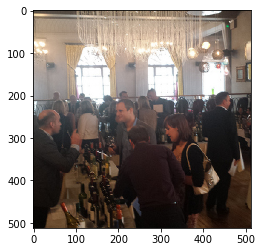

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


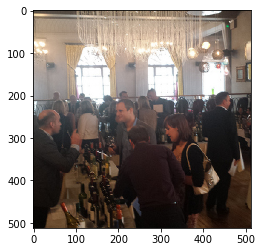

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


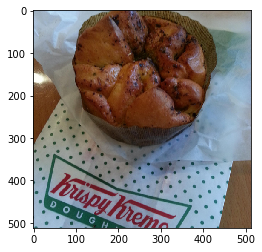

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


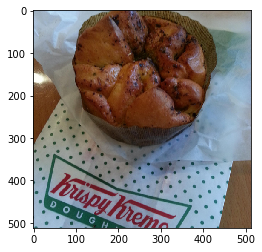

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


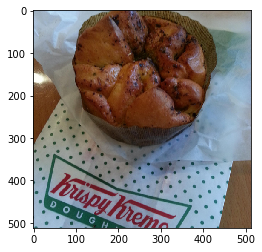

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


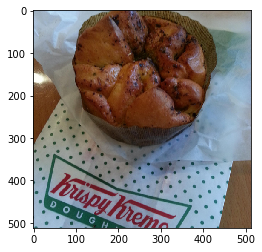

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


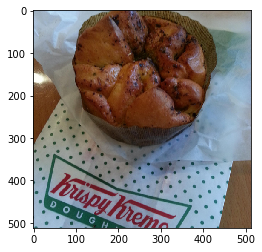

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


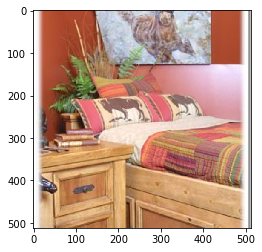

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


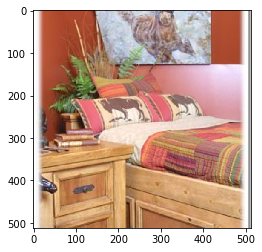

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


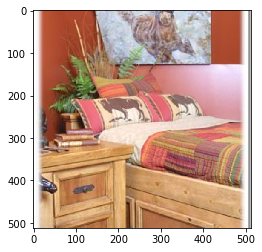

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


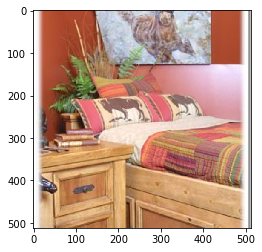

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


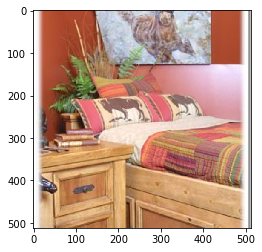

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


IndexError: index 12 is out of bounds for dimension 0 with size 12

In [4]:
if __name__=='__main__':
    with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
        
    with open('TestImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        testIds = list(reader)[0]
    
    trainIds = [int(i) for i in trainIds]
    testIds = [int(i) for i in testIds]
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/images/train/"
    testRoot = "./data/images/test/"
    
    trainValJson = "./data/annotations/captions_train2014.json"
    testJson = "./data/annotations/captions_val2014.json"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 512
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 10
    
    
    trainDl = get_loader(trainValRoot, trainValJson, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=False, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValJson, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testJson, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 56
    hidden_dim = 50
    
    encoder = Encoder(encoded_feature_dim)
    # Turn off all gradients in encoder
    for param in encoder.parameters():
        param.requires_grad = False
    # Turn on gradient of final hidden layer for fine tuning
    for param in encoder.fc.parameters():
        param.requires_grad = True
    decoder = Decoder(encoded_feature_dim, hidden_dim, vocab.idx)
    
    criterion = nn.NLLLoss()
    
    epochs = 100
    trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        trainDl, valDl, testDl, "LSTM",
                        batch_size, encoded_feature_dim, vocab)
    
    
    
    
    
    
    

In [ ]:
%debug

In [14]:
from pycocotools.coco import COCO
coco = COCO("./data/annotations/captions_train2014.json")
with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
trainIds = [int(i) for i in trainIds]
ids = coco.getAnnIds(trainIds)
print("Full trainIDs")
print(len(ids))


random.shuffle(trainIds)
splitIdx = int(len(trainIds)/5)
    
# Selecting 1/5 of training set as validation
valIds = trainIds[:splitIdx]
trainIds = trainIds[splitIdx:]
ids = coco.getAnnIds(trainIds)

print("After trimming:")
print(len(ids))

loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
Full trainIDs
82812
After trimming:
66253


In [ ]:
# Full set: 82812 captions
# Trimmed: 66253